In [177]:
import pandas as pd
import numpy as np
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

style.use('seaborn')
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
data = pd.read_excel('TimeSeriesCoursework.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 2 columns):
Date                                           741 non-null datetime64[ns]
Number of calls received at the call centre    734 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.7 KB


In [3]:
data.rename(columns = {data.columns[1]:'Number'},inplace=True)

# Numeric Summaries

## Overall Summary

In [4]:
data.describe()

,Number
count,734.000000
mean,301.584469
std,188.528394
min,123.000000
25%,171.000000
50%,193.000000
75%,497.000000
max,1049.000000


## day-of-week summary

In [5]:
data['day_of_week'] = data['Date'].dt.dayofweek
data.groupby(data['day_of_week']).describe()
#del data['day_of_week']

Number                                                       \
             count        mean         std    min    25%    50%     75%   
day_of_week                                                               
0            105.0  185.123810   39.690557  125.0  165.0  177.0  198.00   
1            105.0  186.314286   95.876053  123.0  155.0  169.0  181.00   
2            105.0  203.038095  119.753346  132.0  169.0  179.0  196.00   
3            105.0  585.800000   87.697733  433.0  540.0  574.0  605.00   
4            105.0  538.885714   83.899014  195.0  490.0  531.0  577.00   
5            104.0  224.673077  115.025826  141.0  178.0  193.0  215.25   
6            105.0  186.523810   54.442824  126.0  161.0  178.0  196.00   

                     
                max  
day_of_week          
0             455.0  
1             856.0  
2             896.0  
3            1049.0  
4             816.0  
5             772.0  
6             636.0

## month-of-year summary

In [6]:
del data['day_of_week']
data['month_of_year'] = data['Date'].dt.month
data.groupby(data['month_of_year']).describe()

Number                                                        \
               count        mean         std    min     25%    50%     75%   
month_of_year                                                                
1               66.0  307.969697  201.777484  125.0  165.00  191.0  490.25   
2               56.0  292.535714  181.688341  138.0  169.00  185.5  530.50   
3               62.0  342.661290  215.576615  159.0  183.00  212.5  589.25   
4               60.0  330.633333  205.939350  150.0  188.50  211.5  549.00   
5               62.0  311.661290  187.813558  137.0  171.50  195.5  519.00   
6               60.0  284.033333  161.688754  130.0  163.75  193.0  462.25   
7               62.0  268.387097  155.169538  139.0  171.25  187.0  390.25   
8               62.0  281.483871  165.410443  131.0  159.25  179.0  473.75   
9               60.0  272.200000  166.169385  123.0  163.75  178.0  435.50   
10              62.0  269.096774  165.553093  145.0  166.00  179.5  403.00   
11              60.0  307.933333  183.484804  140.0  176.75  205.0  516.75   
12              62.0  348.758065  242.808815  126.0  183.00  202.0  572.50   

                       
                  max  
month_of_year          
1               856.0  
2               658.0  
3               809.0  
4               781.0  
5               680.0  
6               585.0  
7               603.0  
8               576.0  
9               830.0  
10              611.0  
11              700.0  
12             1049.0

In [7]:
del data['month_of_year']

# Graphical Summaries

## time plot

In [8]:
data1 = data.copy()
data1.set_index(data1['Date'],inplace=True)
del data1['Date']


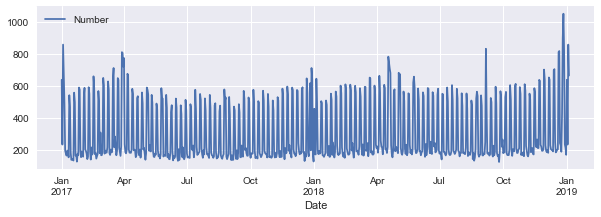

In [104]:
data1.plot(figsize=(10,3))

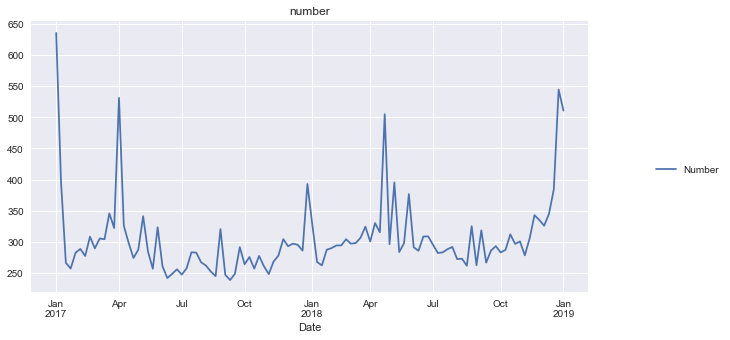

In [44]:
data1_week = data1.resample('W').mean()
data1_week.dropna(inplace=True)
data1_week.plot(figsize=(10,5))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("number")
sns.despine()

## seasonal plot

In [24]:
data2 = data.copy()
data2.set_index(data2['Date'],inplace=True)
data2.head()

,Date,Number
Date,,
2017-01-01,2017-01-01,636.0
2017-01-02,2017-01-02,232.0
2017-01-03,2017-01-03,856.0
2017-01-04,2017-01-04,663.0
2017-01-05,2017-01-05,488.0


In [39]:
data2_month = data2['Number'].resample('M').sum()
data2_month = data2_month.to_frame()
data2_month.reset_index(inplace=True)
data2_month.head()

,Date,Number
0,2017-01-31,9395.0
1,2017-02-28,8114.0
2,2017-03-31,11316.0
3,2017-04-30,9295.0
4,2017-05-31,8925.0


In [40]:
data2_month.loc[:,'month'] = data2_month['Date'].apply(lambda x:x.month)
data2_month.loc[:,'year'] = data2_month['Date'].apply(lambda x:x.year)
data2_month.set_index(data2_month['Date'],inplace=True)
del data2_month['Date']
data2_month.head()

,Number,month,year
Date,,,
2017-01-31,9395.0,1,2017
2017-02-28,8114.0,2,2017
2017-03-31,11316.0,3,2017
2017-04-30,9295.0,4,2017
2017-05-31,8925.0,5,2017


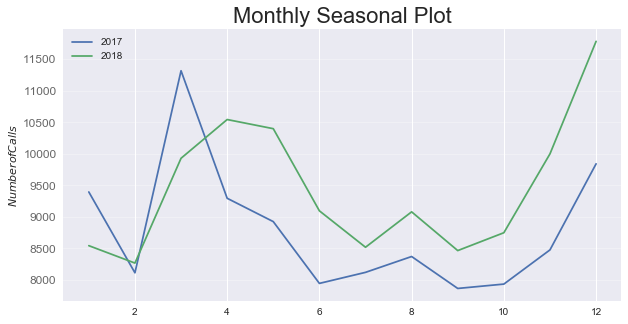

In [43]:
years = [2017,2018]
plt.figure(figsize=(10,5))
for i,y in enumerate(years):
    plt.plot('month','Number',data=data2_month.loc[data2_month.year==y, :],label = y) 
    plt.legend()
#plt.title('Number of calls received at the call centre')

plt.ylabel('$Number of Calls$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly Seasonal Plot", fontsize=22)
plt.grid(axis='y', alpha=.3)

# Decomposition

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
data3 = data.copy()
data3.set_index(data3['Date'],inplace=True)
del data3['Date']
data3.dropna(inplace=True)

In [46]:
decomposition =seasonal_decompose(data3,model='additive')
data3.trend = decomposition.trend
data3.seasonalseasonal = decomposition.seasonal
data3.residual = decomposition.resid

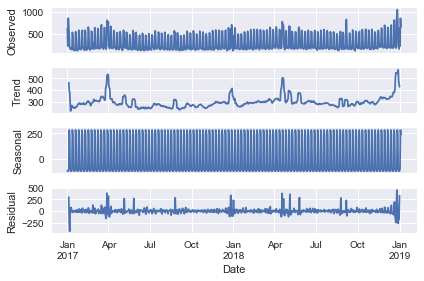

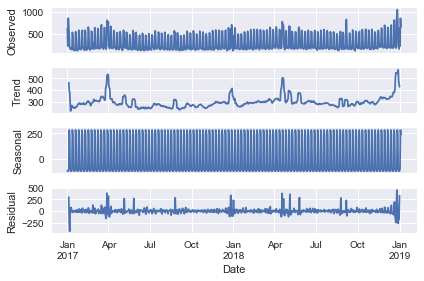

In [48]:
#plt.figure(figsize=(15,5))
decomposition.plot()

# Baseline model

## Naive Forecast 1 
* Use the most recent observation as a forecast

In [49]:
data4 = data.copy()
data4.set_index(data['Date'],inplace=True)
del data4['Date']
data4.rename(columns = {data4.columns[0]:'number'},inplace=True)
data4.head()

,number
Date,
2017-01-01,636.0
2017-01-02,232.0
2017-01-03,856.0
2017-01-04,663.0
2017-01-05,488.0


In [50]:
data4['naive_1'] = data4.shift(1)
data4.head()

,number,naive_1
Date,,
2017-01-01,636.0,NaN
2017-01-02,232.0,636.0
2017-01-03,856.0,232.0
2017-01-04,663.0,856.0
2017-01-05,488.0,663.0


In [52]:
data4.tail(8)

,number,naive_1
Date,,
2019-01-04,663.0,856.0
2019-01-05,NaN,663.0
2019-01-06,NaN,NaN
2019-01-07,NaN,NaN
2019-01-08,NaN,NaN
2019-01-09,NaN,NaN
2019-01-10,NaN,NaN
2019-01-11,NaN,NaN


## Naive Forecast 2
*  Remove seasonality from the original data
*  Use the most recent seasonally adjusted value as a forecast

# Extrapolation Models

### Split the initial set (first 70%) and a test set (remaining 30%)

In [164]:
data5 = data.copy()
data5.set_index(data5['Date'],inplace=True)
del data5['Date']
data5.head()

,Number
Date,
2017-01-01,636.0
2017-01-02,232.0
2017-01-03,856.0
2017-01-04,663.0
2017-01-05,488.0


In [293]:
predict_set = data5[data5.index>='2019-01-05'] # dataset need to be predicted 
train_set = data5[data5.index<'2019-01-05']
init_set = train_set[train_set.index < '2018-05-24']
test_set = train_set[train_set.index >= '2018-05-24']

* observed value for the initialisation set and test set

In [190]:
obs_init = pd.Series(init_set['Number'].values, index=init_set.index)
obs_init.rename('observed',inplace=True)
obs_test = pd.Series(test_set['Number'].values, index=test_set.index)
obs_test.rename('observed',inplace=True)

Date
2018-05-24     620.0
2018-05-25     656.0
2018-05-26     588.0
2018-05-27     205.0
2018-05-28     178.0
2018-05-29     181.0
2018-05-30     201.0
2018-05-31     582.0
2018-06-01     513.0
2018-06-02     190.0
2018-06-03     191.0
2018-06-04     165.0
2018-06-05     182.0
2018-06-06     189.0
2018-06-07     558.0
2018-06-08     535.0
2018-06-09     213.0
2018-06-10     155.0
2018-06-11     235.0
2018-06-12     165.0
2018-06-13     195.0
2018-06-14     585.0
2018-06-15     580.0
2018-06-16     219.0
2018-06-17     178.0
2018-06-18     250.0
2018-06-19     177.0
2018-06-20     173.0
2018-06-21     559.0
2018-06-22     537.0
               ...  
2018-12-06     651.0
2018-12-07     637.0
2018-12-08     227.0
2018-12-09     203.0
2018-12-10     198.0
2018-12-11     197.0
2018-12-12     189.0
2018-12-13     696.0
2018-12-14     703.0
2018-12-15     247.0
2018-12-16     183.0
2018-12-17     190.0
2018-12-18     201.0
2018-12-19     202.0
2018-12-20     810.0
2018-12-21     816.0
2018-12-

## Simple Exponential Smoothing(SES)

In [235]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


#fit1 = SimpleExpSmoothing(init_set).fit(smoothing_level=0.2,optimized=False)
fit1 = SimpleExpSmoothing(init_set).fit()
#predictions for the test set
fcast1 = fit1.forecast(226)

In [232]:
fit1 = SimpleExpSmoothing(init_set).fit(smoothing_level=0.0,optimized=False)

fcast1 = fit1.forecast(226)

In [236]:
fit1.params

{'smoothing_level': 0.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 295.42134617199537,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Error Statistics for initialisation set

In [237]:
MSE(obs_init,fit1.fittedvalues)

33533.168996845445

## Error Statistics for test set

In [238]:
MSE(obs_test,fcast1)

40026.622683318375

In [ ]:
plt.figure(figsize=(10,5))
fit1 = SimpleExpSmoothing(init_set).fit(smoothing_level=0.2,optimized=False)
fit1.fittedvalues.plot(marker='o',  color='blue')
fit2 = SimpleExpSmoothing(init_set).fit(smoothing_level=0.6,optimized=False)
fit2.fittedvalues.plot(marker='o', color='red')
fit3 = SimpleExpSmoothing(data1_week).fit()

obs.plot(marker='*', legend=True)

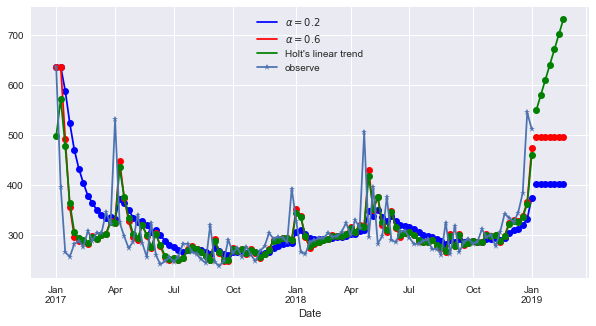

In [111]:
plt.figure(figsize=(10,5))
fit1 = SimpleExpSmoothing(data1_week).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(7).rename(r'$\alpha=0.2$')
#plt.figure(figsize=(10,5))

fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

fit2 = SimpleExpSmoothing(data1_week).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(7).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')

fit3 = SimpleExpSmoothing(data1_week).fit()
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

obs.plot(marker='*', legend=True)

## Holt Linear

In [212]:
#fit2 = Holt(init_set).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fit2 = Holt(init_set).fit()
fcast2 = fit2.forecast(226)

In [209]:
#for i in range(0,10):
    #b = i/10
    #c = 1-b
    #fit2 = Holt(init_set).fit(smoothing_level= b, smoothing_slope= c, optimized=False)
    #print(i)
    #print(MSE(obs_init,fit2.fittedvalues))

In [213]:
fit2.params

{'smoothing_level': 1.8864179244266058e-09,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 290.4616998713255,
 'initial_slope': 0.019546827041174098,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [214]:
MSE(obs_init,fit2.fittedvalues)

33524.82543185039

In [215]:
MSE(obs_test,fcast2)

39723.31849052882

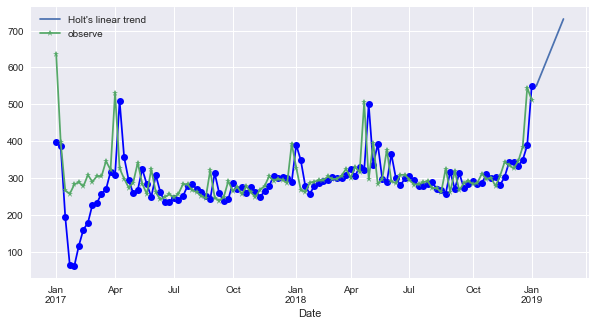

In [96]:
plt.figure(figsize=(10,5))
fit3 = Holt(data1_week).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast3 = fit3.forecast(7).rename("Holt's linear trend")

fit3.fittedvalues.plot(marker="o", color='blue')
fcast3.plot(legend=True)
obs.plot(marker='*',legend=True)

## Holt Winters

In [243]:
#fit3 = ExponentialSmoothing(init_set, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(init_set).fit()
fcast3 = fit3.forecast(226)

In [244]:
MSE(obs_init,fit3.fittedvalues)

33533.168996845445

In [245]:
MSE(obs_test,fcast3)

40026.622683318375

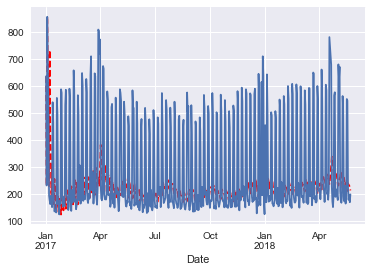

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.


In [154]:
train_set.dropna(inplace=True)
fit1 = ExponentialSmoothing(init_set, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
#fit2 = ExponentialSmoothing(train_set, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
#fit3 = ExponentialSmoothing(train_set, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
#fit4 = ExponentialSmoothing(train_set, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
#fit2.fittedvalues.plot(style='--', color='green')

#fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
#fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)
obs.plot()
plt.show()
print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")


# Regression

## Buit some time features

In [247]:
data.loc[:,'dow'] = data['Date'].apply(lambda x:x.dayofweek)
data.loc[:,'dom'] = data['Date'].apply(lambda x:x.day)
data.loc[:,'month'] = data['Date'].apply(lambda x:x.month)
data.loc[:,'year'] = data['Date'].apply(lambda x:x.year)

In [248]:
data.head()

,Date,Number,dow,dom,month,year
0,2017-01-01,636.0,6,1,1,2017
1,2017-01-02,232.0,0,2,1,2017
2,2017-01-03,856.0,1,3,1,2017
3,2017-01-04,663.0,2,4,1,2017
4,2017-01-05,488.0,3,5,1,2017


## add the weekend as a feature

In [249]:
data.loc[:,'weekend'] = 0
data.loc[:,'weekend_sat'] = 0
data.loc[:,'weekend_sun'] = 0

data.loc[(data['dow']>4),'weekend'] = 1
data.loc[(data['dow']==5),'weekend_sat'] = 1
data.loc[(data['dow']==6),'weekend_sun'] = 1

data.head()

,Date,Number,dow,dom,month,year,weekend,weekend_sat,weekend_sun
0,2017-01-01,636.0,6,1,1,2017,1,0,1
1,2017-01-02,232.0,0,2,1,2017,0,0,0
2,2017-01-03,856.0,1,3,1,2017,0,0,0
3,2017-01-04,663.0,2,4,1,2017,0,0,0
4,2017-01-05,488.0,3,5,1,2017,0,0,0


In [250]:
def week_of_month(day):
    if day in range(1,8):
        return 1
    if day in range(8,15):
        return 2
    if day in range(15,22):
        return 3
    else:
        return 4
data.loc[:,'week_of_month'] = data['dom'].apply(lambda x:week_of_month(x))

In [251]:
data.columns

Index(['Date', 'Number', 'dow', 'dom', 'month', 'year', 'weekend',
       'weekend_sat', 'weekend_sun', 'week_of_month'],
      dtype='object')

In [252]:
var_to_encoding = ['dow', 'dom', 'month', 'year','week_of_month']

In [253]:
dummy_data = pd.get_dummies(data, columns=var_to_encoding)

In [254]:
dummy_data.head()

,Date,Number,weekend,weekend_sat,weekend_sun,dow_0,dow_1,dow_2,dow_3,dow_4,...,month_10,month_11,month_12,year_2017,year_2018,year_2019,week_of_month_1,week_of_month_2,week_of_month_3,week_of_month_4
0,2017-01-01,636.0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2017-01-02,232.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,2017-01-03,856.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,2017-01-04,663.0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,2017-01-05,488.0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [442]:
predict_set = dummy_data[dummy_data.Date>='2019-01-05']
train1_set = dummy_data[dummy_data.Date<'2019-01-05']
init1_set = train1_set[train1_set.index < 513]
test1_set = train1_set[train1_set.index > 513]

In [70]:
from sklearn.linear_model import LinearRegression

In [452]:
drop_columns = ['Date','Number']
init_X = init_set.drop(drop_columns,axis=1)
test_X = test_set.drop(drop_columns,axis=1)
init_y = init_set['Number']
test_y = test_set['Number']
predict_X = predict_set.drop(drop_columns,axis=1)

In [258]:
from sklearn.linear_model import RidgeCV

In [444]:
linear_reg = RidgeCV(alphas=[0.2,0.5,0.8], cv=5)
linear_reg.fit(init_X,init_y)

RidgeCV(alphas=[0.2, 0.5, 0.8], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [445]:
test_pred = linear_reg.predict(test_X)
init_pred = linear_reg.predict(init_X)

In [446]:
MSE(init_y,init_pred)

6740.0423793242935

In [447]:
MSE(test_y,test_pred)

7793.957774450574

In [448]:
linear_reg.score(init_X, init_y)

0.801017690815979

In [449]:
linear_reg.score(test_X, test_y)

0.8011278031973551

In [453]:
predictions_lr = linear_reg.predict(predict_X)

In [455]:
print(predictions_lr)

[245.21394333 174.69862809 176.13547901 170.94076587 197.70593036
 560.13827634 500.71545874]


# ARIMA

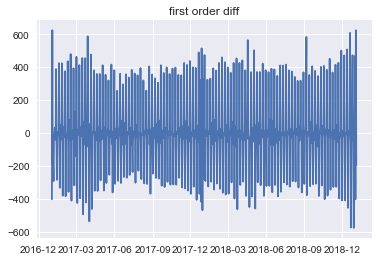

In [295]:
data_diff = train_set.diff()
data_diff = data_diff.dropna()

plt.figure()
plt.plot(data_diff)
plt.title('first order diff')
plt.show()

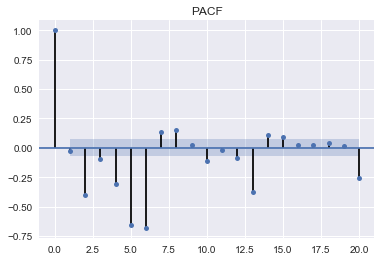

In [296]:
pacf = plot_pacf(data_diff, lags=20)
plt.title("PACF")
pacf.show()

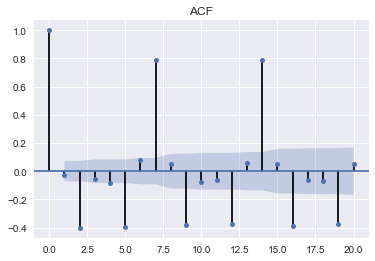

In [297]:
acf = plot_acf(data_diff, lags=20)
plt.title("ACF")
acf.show()

## Choose the optimal parameters for ARIMA

In [394]:
import numpy as np
import itertools

p_min = 6
d_min = 1
q_min = 1
p_max = 10
d_max = 1
q_max = 5

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = ARIMA(init_set, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

In [395]:
results_bic

,MA1,MA2,MA3,MA4,MA5
AR6,6169.860962,6155.858069,6153.400236,6150.129311,6123.836398
AR7,6164.195550,6155.724703,6151.417034,6147.186077,6116.800111
AR8,6162.587758,6121.431109,6127.429208,6126.475223,6103.459396
AR9,6158.869997,6127.471895,6132.694395,6118.959489,6091.503352
AR10,6130.608917,6140.607690,6127.279929,6096.280531,6095.170632


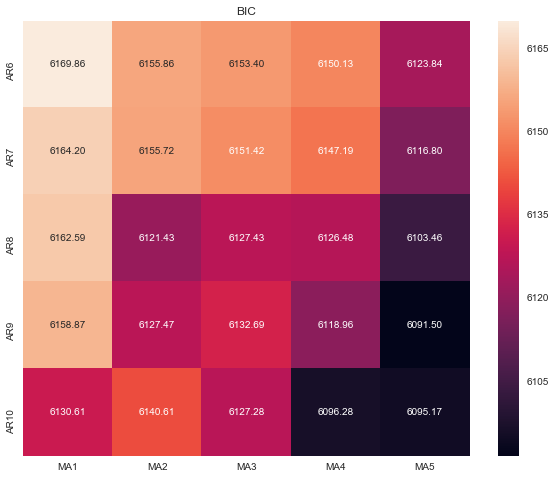

In [396]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

* From the plot, we can see when p = 8, q = 5, ARIMA will get the best result

In [397]:
model = ARIMA(init_set, order=(10, 1, 5),freq='D')

In [398]:
result = model.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Number   No. Observations:                  507
Model:                ARIMA(10, 1, 5)   Log Likelihood               -2994.643
Method:                       css-mle   S.D. of innovations             87.550
Date:                Mon, 25 Mar 2019   AIC                           6023.286
Time:                        16:30:37   BIC                           6095.171
Sample:                    01-02-2017   HQIC                          6051.477
                         - 05-23-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4237      1.211     -0.350      0.727      -2.798       1.950
ar.L1.D.Number     -0.4831        nan        nan        nan         nan         nan
ar.L2.D.Number     -1.3310      

In [416]:
#init_pred = result.predict('20170101','20180523',dynamic=True, typ='levels')
init_pred = result.predict('20180524','20190104',dynamic=True, typ='levels')

In [432]:
pred = result.predict('20180524','20190111',dynamic=True, typ='levels')

In [ ]:
train

In [433]:
a = obs_init.to_frame()
b = a.iloc[1:,::]

In [402]:
MSE(b.values,result.fittedvalues)

127255.67018111084

In [403]:
MSE(obs_test,init_pred)

16794.708336468684

In [435]:
prediction_arima = pred.tail(7)
print(prediction_arima)

2019-01-05    193.391033
2019-01-06     79.241298
2019-01-07     99.358641
2019-01-08     34.300112
2019-01-09    119.882695
2019-01-10    411.988560
2019-01-11    449.919874
Freq: D, dtype: float64
